In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import math
from IPython.display import display, HTML

In [5]:
class FCT:

    def __init__(self, folder, toponame, flownum, loads, algs):
        self.flownum = flownum
        self.loads = loads
        self.algs = algs
        self.raw_data = [[0 for i in range(len(loads))] for i in range(len(algs))]
        for alg_i in range(len(algs)):
            for load_i in range(len(loads)):
                alg = algs[alg_i]
                load = loads[load_i]
                # print("tcp_"+alg+"_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr")
                self.raw_data[alg_i][load_i] = \
                    self.parse_trace(folder, filename="tcp_"+alg+"_flow_"+str(flownum)+"_"+str(load)+"_"+toponame+".tr")
                    
    # At least two
    def plotting_mean_FCT(self):
        plt.figure(figsize=(8,5))
        # base = [15,25]
        # time = 10
        # plt.yticks([self.scaling(x, base, time) for x in [10,15,20,25,30,40]],[10,15,20,25,30,40])
        plt.yscale('log', basey= 10)
        # plt.ylim(10, 60)
        # plt.yticks(np.arange(min(x), max(x)+1, 1.0))
        plt.grid()
        plt.xlabel("Link utilization")
        plt.ylabel("Normalized FCT")
        plt.title("Normalized FCT")
        for alg_i in range(len(self.algs)):
            alg = self.algs[alg_i]
            load_means = [0 for i in range(len(self.loads))]
            for load_i in range(len(self.loads)):
                load = self.loads[load_i]
                load_means[load_i] = self.raw_data[alg_i][load_i]["Normalized FCT"].mean()
            #scaled_load_means = [self.scaling(x, base, time) for x in load_means]
            #plt.plot(self.loads, scaled_load_means, label=alg)
            plt.plot(self.loads, load_means, label=alg)
        plt.legend(loc='best')
        plt.show()
    
    # Normalized FCT = Actual FCT / min FCT
    # min FCT = flow_size / max bandwidth
    def parse_trace(self, dir, filename):
        col = ["tmp_pkts", "flow duration", "fin_fid", "rtt times", \
                   "group_id", "Tw_", "Tp_", "Np_", "?1", "?2", "?3", "?4", "?5", "Average rate", "start time"]
        df = pd.read_csv(dir+filename, sep = ' ', header = None)
        df.columns = col
        df["Normalized FCT"] = 40 * 1e9 / df["Average rate"]
        return df
    
    def get_load_id(self, load):
        return self.loads.index(load)
    
    def get_alg_id(self, alg):
        return self.algs.index(alg)
    
    def humanbytes(self, B):
        B = float(B)
        KB = float(1000)
        MB = float(KB ** 2)
        GB = float(KB ** 3)
        TB = float(KB ** 4) 

        if B < KB:
            return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
        elif KB <= B < MB:
            return '{0:.2f} KB'.format(B/KB)
        elif MB <= B < GB:
            return '{0:.2f} MB'.format(B/MB)
        elif GB <= B < TB:
            return '{0:.2f} GB'.format(B/GB)
        elif TB <= B:
            return '{0:.2f} TB'.format(B/TB)
        
    def plot_FCT_flowsize(self, alg, load, color=None, scale=[0,0], label=None):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df=self.raw_data[alg_id][load_id]
        y = df['Normalized FCT']
        x = df['tmp_pkts']
        plt.yscale('log')
        plt.scatter(x, y, color=color, label=label)
        plt.xlabel('flow size')
        plt.ylabel('Normalized FCT')
        plt.legend()
        plt.show()
        
    def scaling(self, x, base, time):
        if (x < base[0]):
            return base[0] - x / time
        elif (x > base[1]):
            return base[1] + x / time
        else:
            return x
        return x if (base == 0 or x<base) else base + x / time
    
    def plot_one_FCT_percentile(self, alg, load, percentile, flow_size, scale=[0,0], isLast=False):
        alg_id=self.get_alg_id(alg)
        load_id=self.get_load_id(load)
        df = self.raw_data[alg_id][load_id]
        # cut -> (,]
        cate=pd.cut(df["tmp_pkts"], flow_size, labels=flow_size[:-1])
        selected_flow=[]
        corresponding_flow_size=[]
        for label in flow_size[:-1]:
            seg_data=df[cate == label]
            res=seg_data.sort_values(by=['Normalized FCT'])
            res.reset_index(inplace=True)
            if res.shape[0] == 0:
                continue
            # print(label)
            # display(seg_data)
            # 16 indicate col 'Normalized FCT' 
            # print(res.iloc[[math.ceil((res.shape[0]-1) * 0.95)]])
            # selected_flow.append(res.iloc[math.ceil((res.shape[0]-1) * 0.95), 16])
            selected_flow.append(res.iloc[:, 16].mean())
            corresponding_flow_size.append(label)
        len_range=[i for i in range(len(corresponding_flow_size))]
        plt.plot(len_range, selected_flow, label=alg)
        plt.yscale('log')
        if (isLast):
            plt.xlabel('flow size')
            plt.ylabel('Normalized FCT')
            #plt.title("load:"+str(load)+" percentile:"+str(percentile))
            plt.title("load:"+str(load)+" mean")
            plt.grid()
            plt.legend()
            #plt.yticks([0,50,100,150,200])
            plt.xticks(len_range, [self.humanbytes(i*1500) for i in corresponding_flow_size])
            plt.show()
            
    def plot_FCT_percentile_fix_load(self, algs, load, percentile, flow_size, scale=[0,0]):
        fig= plt.figure(figsize=(18,3))
        for alg in algs:
            if alg == algs[-1]:
                self.plot_one_FCT_percentile(alg , load, percentile, flow_size, scale, True)
            else:
                self.plot_one_FCT_percentile(alg , load, percentile, flow_size, scale, False)

In [ ]:
if __name__ == '__main__':
    flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, float('inf')]
    # print([FCT_analysis.humanbytes(i*1500) for i in flow_size])
    algs=["DropTail"]

    
    FCT_analysis_small = FCT("/home/ovs2/lining/Gearbox/manual/DropTail/", \
                       "Topology-incast-singlenode-small.tcl",\
                       10, \
                       [.5], \
                       ["DropTail"])
    for load in [.5]:
        FCT_analysis_small.plot_FCT_percentile_fix_load(algs, load, .95, flow_size)
    
    
    FCT_analysis_normal = FCT("/home/ovs2/lining/Gearbox/manual/DropTail/", \
                       "Topology-incast-singlenode.tcl",\
                       10, \
                       [.5], \
                       ["DropTail"])
    for load in [.5]:
        FCT_analysis_normal.plot_FCT_percentile_fix_load(algs, load, .95, flow_size)        
    
    
    FCT_analysis_big = FCT("/home/ovs2/lining/Gearbox/manual/DropTail/", \
                       "Topology-incast-singlenode-big.tcl",\
                       10, \
                       [.5], \
                       ["DropTail"])
    for load in [.5]:
        FCT_analysis_big.plot_FCT_percentile_fix_load(algs, load, .95, flow_size)    

33


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
3,47.0,0.000094,14,0,0,0,0,3,1,1,0.0,0.0,0,5.834091e+09,1.018489,6.856252
11,52.0,0.000096,8,0,0,1,1,3,1,1,0.0,0.0,0,6.353457e+09,1.046890,6.295785
17,52.0,0.000096,40,0,0,0,1,3,1,1,0.0,0.0,0,6.353457e+09,1.055705,6.295785
23,39.0,0.000092,26,0,0,0,0,3,1,1,0.0,0.0,0,4.967763e+09,1.065242,8.051914
26,39.0,0.000092,58,0,0,1,0,3,1,1,0.0,0.0,0,4.967763e+09,1.075243,8.051914
29,50.0,0.000095,60,0,0,0,0,3,1,1,0.0,0.0,0,6.147679e+09,1.081853,6.506521
30,46.0,0.000094,66,0,0,0,1,3,1,1,0.0,0.0,0,5.728225e+09,1.092492,6.982966
31,38.0,0.000091,62,0,0,1,0,3,1,1,0.0,0.0,0,4.856273e+09,1.095324,8.236770
40,44.0,0.000093,68,0,0,0,0,3,1,1,0.0,0.0,0,5.514447e+09,1.109108,7.253674
41,40.0,0.000092,78,0,0,0,0,3,1,1,0.0,0.0,0,5.078526e+09,1.111507,7.876301


53


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
7,120.0,0.000119,20,0,0,1,0,3,1,1,0.0,0.0,0,1.174664e+10,1.027345,3.405228
16,117.0,0.000118,38,0,0,1,1,3,1,1,0.0,0.0,0,1.154002e+10,1.052791,3.466198
20,80.0,0.000107,48,0,0,1,1,3,1,1,0.0,0.0,0,8.706737e+09,1.057144,4.594144
27,64.0,0.000103,56,0,0,0,0,3,1,1,0.0,0.0,0,7.291512e+09,1.077193,5.485830
64,133.0,0.000123,132,0,0,1,0,3,1,1,0.0,0.0,0,1.260713e+10,1.154518,3.172809
68,67.0,0.000103,130,0,0,0,0,3,1,1,0.0,0.0,0,7.566873e+09,1.175185,5.286199
83,61.0,0.000098,172,0,0,1,0,3,1,1,0.0,0.0,0,7.248370e+09,1.208009,5.518482
134,75.0,0.000106,278,0,0,0,1,3,1,1,0.0,0.0,0,8.278271e+09,1.341455,4.831927
146,73.0,0.000105,300,0,0,0,1,3,1,1,0.0,0.0,0,8.103464e+09,1.374112,4.936161
153,77.0,0.000106,304,0,0,0,0,3,1,1,0.0,0.0,0,8.451107e+09,1.392351,4.733108


133


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
4,406.0,0.000205,16,0,0,0,0,3,1,1,0.0,0.0,0,2.311865e+10,1.018619,1.730204
10,547.0,0.000247,24,0,0,1,0,3,1,1,0.0,0.0,0,2.582241e+10,1.039962,1.549042
15,1131.0,0.000423,36,0,0,0,1,3,1,1,0.0,0.0,0,3.125764e+10,1.052034,1.279687
19,319.0,0.000179,42,0,0,1,1,3,1,1,0.0,0.0,0,2.081110e+10,1.056467,1.922051
22,1075.0,0.000406,50,0,0,1,1,3,1,1,0.0,0.0,0,3.093989e+10,1.059705,1.292830
25,1189.0,0.000440,34,0,0,0,0,3,1,1,0.0,0.0,0,3.156117e+10,1.067302,1.267380
37,874.0,0.001534,76,0,0,1,1,3,1,1,0.0,0.0,0,6.655916e+09,1.104613,6.009691
43,342.0,0.000186,84,0,0,1,0,3,1,1,0.0,0.0,0,2.148546e+10,1.117658,1.861724
47,670.0,0.000909,96,0,0,0,0,3,1,1,0.0,0.0,0,8.612345e+09,1.125639,4.644496
53,491.0,0.001448,112,0,0,0,1,3,1,1,0.0,0.0,0,3.961306e+09,1.136730,10.097679


1333


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
8,2566.0,0.000853,18,0,0,0,0,3,1,1,0.0,0.0,0,3.513094e+10,1.031098,1.138597
9,1998.0,0.000683,12,0,0,0,1,3,1,1,0.0,0.0,0,3.418190e+10,1.034562,1.170210
21,1508.0,0.000536,44,0,0,0,1,3,1,1,0.0,0.0,0,3.287812e+10,1.058451,1.216615
34,2230.0,0.000754,64,0,0,0,0,3,1,1,0.0,0.0,0,3.452437e+10,1.099902,1.158602
38,2663.0,0.003882,82,0,0,1,0,3,1,1,0.0,0.0,0,8.011452e+09,1.102433,4.992852
46,2212.0,0.000801,88,0,0,1,0,3,1,1,0.0,0.0,0,3.224763e+10,1.125601,1.240401
59,2109.0,0.000716,120,0,0,0,0,3,1,1,0.0,0.0,0,3.440288e+10,1.149692,1.162693
65,1453.0,0.000519,134,0,0,1,0,3,1,1,0.0,0.0,0,3.268569e+10,1.160264,1.223777
86,1783.0,0.000618,176,0,0,0,1,3,1,1,0.0,0.0,0,3.368617e+10,1.213720,1.187431
87,2548.0,0.000848,180,0,0,0,0,3,1,1,0.0,0.0,0,3.509364e+10,1.216497,1.139808


3333


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
0,5326.0,0.001796,7,0,0,1,1,3,1,1,0.0,0.0,0,3.463550e+10,1.013988,1.154885
1,4801.0,0.003888,6,0,0,1,0,3,1,1,0.0,0.0,0,1.442416e+10,1.014218,2.773126
2,4276.0,0.003958,5,0,0,0,1,3,1,1,0.0,0.0,0,1.261851e+10,1.014454,3.169946
6,3750.0,0.005529,4,1,0,0,0,3,1,1,0.0,0.0,0,7.922485e+09,1.014696,5.048921
12,6146.0,0.001927,22,0,0,0,0,3,1,1,0.0,0.0,0,3.725005e+10,1.047638,1.073824
50,4634.0,0.001474,74,0,0,0,1,3,1,1,0.0,0.0,0,3.673187e+10,1.132495,1.088973
52,5460.0,0.001816,104,0,0,1,0,3,1,1,0.0,0.0,0,3.511457e+10,1.136266,1.139128
127,3714.0,0.001198,252,0,0,0,0,3,1,1,0.0,0.0,0,3.622449e+10,1.324891,1.104225
143,5762.0,0.001812,296,0,0,0,1,3,1,1,0.0,0.0,0,3.714302e+10,1.364292,1.076918
157,6444.0,0.002021,294,0,0,1,1,3,1,1,0.0,0.0,0,3.724127e+10,1.412632,1.074077


6667


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
36,15205.0,0.005151,72,0,0,1,0,3,1,1,0.0,0.0,0,3.447661e+10,1.100372,1.160207
131,8937.0,0.002896,270,0,0,1,1,3,1,1,0.0,0.0,0,3.604573e+10,1.335340,1.109702
198,16772.0,0.005125,396,0,0,1,0,3,1,1,0.0,0.0,0,3.822714e+10,1.514707,1.046377
203,16295.0,0.004978,400,0,0,1,1,3,1,1,0.0,0.0,0,3.822988e+10,1.525978,1.046302
255,11278.0,0.003509,520,0,0,1,0,3,1,1,0.0,0.0,0,3.753618e+10,1.672445,1.065639
303,7605.0,0.002593,614,0,0,0,0,3,1,1,0.0,0.0,0,3.425530e+10,1.779890,1.167702
310,18602.0,0.008342,618,0,0,0,1,3,1,1,0.0,0.0,0,2.604667e+10,1.786369,1.535705
370,13604.0,0.004216,746,0,0,1,0,3,1,1,0.0,0.0,0,3.768658e+10,1.957503,1.061386
376,9243.0,0.002861,742,0,0,0,0,3,1,1,0.0,0.0,0,3.773522e+10,1.975434,1.060018
409,13187.0,0.004039,824,0,0,1,0,3,1,1,0.0,0.0,0,3.813027e+10,2.060992,1.049035


0


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
13,6.0,0.000051,28,0,0,0,1,3,1,1,0.0,0.0,0,1.362809e+09,1.049668,29.351142
14,6.0,0.000051,32,0,0,1,1,3,1,1,0.0,0.0,0,1.362809e+09,1.050374,29.351142
18,6.0,0.000051,30,0,0,1,0,3,1,1,0.0,0.0,0,1.362809e+09,1.056516,29.351142
28,6.0,0.000051,52,0,0,0,1,3,1,1,0.0,0.0,0,1.362809e+09,1.078724,29.351142
35,6.0,0.000602,80,0,0,1,0,3,1,1,0.0,0.0,0,1.164972e+08,1.101531,343.355765
38,6.0,0.000051,88,0,0,1,1,3,1,1,0.0,0.0,0,1.362809e+09,1.107510,29.351142
42,6.0,0.000051,92,0,0,0,0,3,1,1,0.0,0.0,0,1.362809e+09,1.112820,29.351142
45,6.0,0.000069,90,0,0,1,1,3,1,1,0.0,0.0,0,1.014914e+09,1.125656,39.412215
48,6.0,0.000059,100,0,0,1,0,3,1,1,0.0,0.0,0,1.188492e+09,1.126534,33.656107
49,6.0,0.000051,102,0,0,0,0,3,1,1,0.0,0.0,0,1.362809e+09,1.131337,29.351142


6


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
5,10.0,0.000065,10,0,0,1,0,3,1,1,0.0,0.0,0,1.801435e+09,1.019617,22.204520
24,11.0,0.000065,46,0,0,1,0,3,1,1,0.0,0.0,0,1.987402e+09,1.067255,20.126775
71,7.0,0.000052,148,0,0,1,0,3,1,1,0.0,0.0,0,1.580722e+09,1.176263,25.304892
77,8.0,0.000065,146,0,0,1,1,3,1,1,0.0,0.0,0,1.435699e+09,1.188343,27.861002
84,11.0,0.000065,160,0,0,0,0,3,1,1,0.0,0.0,0,1.987402e+09,1.212192,20.126775
103,10.0,0.000064,216,0,0,1,0,3,1,1,0.0,0.0,0,1.815153e+09,1.260733,22.036712
107,10.0,0.000064,226,0,0,0,1,3,1,1,0.0,0.0,0,1.815153e+09,1.270659,22.036712
141,7.0,0.000052,284,0,0,0,1,3,1,1,0.0,0.0,0,1.580722e+09,1.362119,25.304892
154,12.0,0.000065,316,0,0,0,0,3,1,1,0.0,0.0,0,2.158061e+09,1.407724,18.535160
155,11.0,0.000065,312,0,0,1,0,3,1,1,0.0,0.0,0,1.987402e+09,1.409166,20.126775


13


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
32,16.0,0.000077,70,0,0,0,1,3,1,1,0.0,0.0,0,2.437421e+09,1.097344,16.410788
44,15.0,0.000066,96,0,0,0,0,3,1,1,0.0,0.0,0,2.660705e+09,1.120816,15.033607
51,16.0,0.000077,94,0,0,1,1,3,1,1,0.0,0.0,0,2.437421e+09,1.133980,16.410788
57,17.0,0.000077,104,0,0,1,1,3,1,1,0.0,0.0,0,2.579666e+09,1.148143,15.505882
60,17.0,0.000104,124,0,0,1,0,3,1,1,0.0,0.0,0,1.900418e+09,1.150368,21.048006
81,17.0,0.000077,170,0,0,1,0,3,1,1,0.0,0.0,0,2.579666e+09,1.200527,15.505882
90,18.0,0.000077,180,0,0,1,0,3,1,1,0.0,0.0,0,2.720807e+09,1.223515,14.701522
91,16.0,0.000077,154,0,0,1,1,3,1,1,0.0,0.0,0,2.437421e+09,1.224717,16.410788
99,18.0,0.000077,208,0,0,0,1,3,1,1,0.0,0.0,0,2.720807e+09,1.252077,14.701522
111,14.0,0.000066,206,0,0,0,0,3,1,1,0.0,0.0,0,2.494691e+09,1.290769,16.034051


19


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
33,29.0,0.000081,54,0,0,1,1,3,1,1,0.0,0.0,0,4.203984e+09,1.099365,9.514785
56,20.0,0.000078,112,0,0,0,0,3,1,1,0.0,0.0,0,2.999825e+09,1.148139,13.334110
61,30.0,0.000081,130,0,0,1,0,3,1,1,0.0,0.0,0,4.332816e+09,1.152619,9.231872
63,32.0,0.000090,126,0,0,0,0,3,1,1,0.0,0.0,0,4.171652e+09,1.154424,9.588527
70,31.0,0.000099,138,0,0,1,1,3,1,1,0.0,0.0,0,3.646600e+09,1.176186,10.969123
80,33.0,0.000090,166,0,0,1,0,3,1,1,0.0,0.0,0,4.287659e+09,1.196277,9.329099
92,21.0,0.000078,184,0,0,0,0,3,1,1,0.0,0.0,0,3.137728e+09,1.224892,12.748076
110,30.0,0.000081,220,0,0,1,0,3,1,1,0.0,0.0,0,4.332816e+09,1.286410,9.231872
138,26.0,0.000080,268,0,0,0,0,3,1,1,0.0,0.0,0,3.811666e+09,1.356995,10.494099
140,31.0,0.000081,276,0,0,1,1,3,1,1,0.0,0.0,0,4.460695e+09,1.360200,8.967212


33


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
3,47.0,0.000094,14,0,0,0,0,3,1,1,0.0,0.0,0,5.834091e+09,1.018489,6.856252
11,52.0,0.000096,8,0,0,1,1,3,1,1,0.0,0.0,0,6.353457e+09,1.046890,6.295785
17,52.0,0.000096,40,0,0,0,1,3,1,1,0.0,0.0,0,6.353457e+09,1.055705,6.295785
23,39.0,0.000092,26,0,0,0,0,3,1,1,0.0,0.0,0,4.967763e+09,1.065242,8.051914
26,39.0,0.000092,58,0,0,1,0,3,1,1,0.0,0.0,0,4.967763e+09,1.075243,8.051914
29,50.0,0.000095,60,0,0,0,0,3,1,1,0.0,0.0,0,6.147679e+09,1.081853,6.506521
30,46.0,0.000094,66,0,0,0,1,3,1,1,0.0,0.0,0,5.728225e+09,1.092492,6.982966
31,38.0,0.000091,62,0,0,1,0,3,1,1,0.0,0.0,0,4.856273e+09,1.095324,8.236770
39,44.0,0.000095,68,0,0,0,0,3,1,1,0.0,0.0,0,5.428472e+09,1.109108,7.368555
41,40.0,0.000092,78,0,0,0,0,3,1,1,0.0,0.0,0,5.078526e+09,1.111507,7.876301


53


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
7,120.0,0.000119,20,0,0,1,0,3,1,1,0.0,0.0,0,1.174664e+10,1.027345,3.405228
16,117.0,0.000118,38,0,0,1,1,3,1,1,0.0,0.0,0,1.154002e+10,1.052791,3.466198
20,80.0,0.000107,48,0,0,1,1,3,1,1,0.0,0.0,0,8.706737e+09,1.057144,4.594144
27,64.0,0.000103,56,0,0,0,0,3,1,1,0.0,0.0,0,7.291512e+09,1.077193,5.485830
64,133.0,0.000123,134,0,0,1,0,3,1,1,0.0,0.0,0,1.260713e+10,1.154518,3.172809
68,67.0,0.000103,132,0,0,0,0,3,1,1,0.0,0.0,0,7.566873e+09,1.175185,5.286199
83,61.0,0.000098,174,0,0,1,0,3,1,1,0.0,0.0,0,7.248370e+09,1.208009,5.518482
134,75.0,0.000106,278,0,0,0,1,3,1,1,0.0,0.0,0,8.278271e+09,1.341455,4.831927
146,73.0,0.000105,300,0,0,0,1,3,1,1,0.0,0.0,0,8.103464e+09,1.374112,4.936161
153,77.0,0.000106,304,0,0,0,0,3,1,1,0.0,0.0,0,8.451107e+09,1.392351,4.733108


133


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
4,406.0,0.000205,16,0,0,0,0,3,1,1,0.0,0.0,0,2.311865e+10,1.018619,1.730204
10,547.0,0.000247,24,0,0,1,0,3,1,1,0.0,0.0,0,2.582241e+10,1.039962,1.549042
15,1131.0,0.000423,36,0,0,0,1,3,1,1,0.0,0.0,0,3.125764e+10,1.052034,1.279687
19,319.0,0.000179,42,0,0,1,1,3,1,1,0.0,0.0,0,2.081110e+10,1.056467,1.922051
22,1075.0,0.000406,50,0,0,1,1,3,1,1,0.0,0.0,0,3.093989e+10,1.059705,1.292830
25,1189.0,0.000440,34,0,0,0,0,3,1,1,0.0,0.0,0,3.156117e+10,1.067302,1.267380
40,874.0,0.004710,76,1,0,1,1,3,1,1,0.0,0.0,0,2.167517e+09,1.104613,18.454297
43,342.0,0.000186,84,0,0,1,0,3,1,1,0.0,0.0,0,2.148546e+10,1.117658,1.861724
47,670.0,0.000919,98,0,0,0,0,3,1,1,0.0,0.0,0,8.511171e+09,1.125639,4.699706
53,491.0,0.001418,114,0,0,0,1,3,1,1,0.0,0.0,0,4.044408e+09,1.136730,9.890199


1333


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
8,2566.0,0.000853,18,0,0,0,0,3,1,1,0.0,0.0,0,3.513094e+10,1.031098,1.138597
9,1998.0,0.000683,12,0,0,0,1,3,1,1,0.0,0.0,0,3.418190e+10,1.034562,1.170210
21,1508.0,0.000536,44,0,0,0,1,3,1,1,0.0,0.0,0,3.287812e+10,1.058451,1.216615
34,2230.0,0.000752,64,0,0,0,0,3,1,1,0.0,0.0,0,3.462111e+10,1.099902,1.155365
37,2663.0,0.003731,82,0,0,1,0,3,1,1,0.0,0.0,0,8.335720e+09,1.102433,4.798626
46,2212.0,0.000807,86,0,0,1,0,3,1,1,0.0,0.0,0,3.203173e+10,1.125601,1.248762
59,2109.0,0.000716,122,0,0,0,0,3,1,1,0.0,0.0,0,3.440288e+10,1.149692,1.162693
65,1453.0,0.000519,136,0,0,1,0,3,1,1,0.0,0.0,0,3.268569e+10,1.160264,1.223777
86,1783.0,0.000618,178,0,0,0,1,3,1,1,0.0,0.0,0,3.368617e+10,1.213720,1.187431
87,2548.0,0.000848,182,0,0,0,0,3,1,1,0.0,0.0,0,3.510639e+10,1.216497,1.139394


3333


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
0,5326.0,0.001721,7,0,0,1,1,3,1,1,0.0,0.0,0,3.615113e+10,1.013988,1.106466
1,4801.0,0.003865,6,0,0,1,0,3,1,1,0.0,0.0,0,1.450816e+10,1.014218,2.757069
2,4276.0,0.003974,5,0,0,0,1,3,1,1,0.0,0.0,0,1.256805e+10,1.014454,3.182673
6,3750.0,0.006044,4,1,0,0,0,3,1,1,0.0,0.0,0,7.246267e+09,1.014696,5.520083
12,6146.0,0.001927,22,0,0,0,0,3,1,1,0.0,0.0,0,3.725005e+10,1.047638,1.073824
50,4634.0,0.001474,74,0,0,0,1,3,1,1,0.0,0.0,0,3.673187e+10,1.132495,1.088973
52,5460.0,0.001753,106,0,0,1,0,3,1,1,0.0,0.0,0,3.638266e+10,1.136266,1.099425
127,3714.0,0.001198,254,0,0,0,0,3,1,1,0.0,0.0,0,3.622449e+10,1.324891,1.104225
143,5762.0,0.001812,296,0,0,0,1,3,1,1,0.0,0.0,0,3.714302e+10,1.364292,1.076918
157,6444.0,0.002017,294,0,0,1,1,3,1,1,0.0,0.0,0,3.731883e+10,1.412632,1.071845


6667


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
36,15205.0,0.004999,72,0,0,1,0,3,1,1,0.0,0.0,0,3.552524e+10,1.100372,1.125960
131,8937.0,0.002927,260,0,0,1,1,3,1,1,0.0,0.0,0,3.566478e+10,1.335340,1.121555
198,16772.0,0.005125,396,0,0,1,0,3,1,1,0.0,0.0,0,3.822714e+10,1.514707,1.046377
203,16295.0,0.004978,400,0,0,1,1,3,1,1,0.0,0.0,0,3.822988e+10,1.525978,1.046302
255,11278.0,0.003476,520,0,0,1,0,3,1,1,0.0,0.0,0,3.789577e+10,1.672445,1.055527
303,7605.0,0.002620,614,0,0,0,0,3,1,1,0.0,0.0,0,3.390965e+10,1.779890,1.179605
311,18602.0,0.008375,618,0,0,0,1,3,1,1,0.0,0.0,0,2.594352e+10,1.786369,1.541811
370,13604.0,0.004216,746,0,0,1,0,3,1,1,0.0,0.0,0,3.768658e+10,1.957503,1.061386
375,9243.0,0.002859,744,0,0,0,0,3,1,1,0.0,0.0,0,3.775908e+10,1.975434,1.059348
409,13187.0,0.004039,824,0,0,1,0,3,1,1,0.0,0.0,0,3.813027e+10,2.060992,1.049035


0


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
13,6.0,0.000051,30,0,0,0,1,3,1,1,0.0,0.0,0,1.362809e+09,1.049668,29.351142
14,6.0,0.000051,34,0,0,1,1,3,1,1,0.0,0.0,0,1.362809e+09,1.050374,29.351142
18,6.0,0.000051,32,0,0,1,0,3,1,1,0.0,0.0,0,1.362809e+09,1.056516,29.351142
28,6.0,0.000051,54,0,0,0,1,3,1,1,0.0,0.0,0,1.362809e+09,1.078724,29.351142
35,6.0,0.001202,82,0,0,1,0,3,1,1,0.0,0.0,0,5.832328e+07,1.101531,685.832477
39,6.0,0.000051,90,0,0,1,1,3,1,1,0.0,0.0,0,1.362809e+09,1.107510,29.351142
42,6.0,0.000051,80,0,0,0,0,3,1,1,0.0,0.0,0,1.362809e+09,1.112820,29.351142
45,6.0,0.000069,94,0,0,1,1,3,1,1,0.0,0.0,0,1.014914e+09,1.125656,39.412215
48,6.0,0.000085,92,0,0,1,0,3,1,1,0.0,0.0,0,8.198342e+08,1.126534,48.790354
49,6.0,0.000051,100,0,0,0,0,3,1,1,0.0,0.0,0,1.362809e+09,1.131337,29.351142


6


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
6,10.0,0.000093,10,0,0,1,0,3,1,1,0.0,0.0,0,1.254640e+09,1.019617,31.881644
24,11.0,0.000065,48,0,0,1,0,3,1,1,0.0,0.0,0,1.987402e+09,1.067255,20.126775
71,7.0,0.000052,146,0,0,1,0,3,1,1,0.0,0.0,0,1.580722e+09,1.176263,25.304892
77,8.0,0.000065,156,0,0,1,1,3,1,1,0.0,0.0,0,1.435699e+09,1.188343,27.861002
84,11.0,0.000065,152,0,0,0,0,3,1,1,0.0,0.0,0,1.987402e+09,1.212192,20.126775
103,10.0,0.000064,204,0,0,1,0,3,1,1,0.0,0.0,0,1.815153e+09,1.260733,22.036712
107,10.0,0.000064,228,0,0,0,1,3,1,1,0.0,0.0,0,1.815153e+09,1.270659,22.036712
141,7.0,0.000052,288,0,0,0,1,3,1,1,0.0,0.0,0,1.580722e+09,1.362119,25.304892
154,12.0,0.000065,308,0,0,0,0,3,1,1,0.0,0.0,0,2.158061e+09,1.407724,18.535160
155,11.0,0.000065,314,0,0,1,0,3,1,1,0.0,0.0,0,1.987402e+09,1.409166,20.126775


13


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
32,16.0,0.000077,72,0,0,0,1,3,1,1,0.0,0.0,0,2.437421e+09,1.097344,16.410788
44,15.0,0.000066,96,0,0,0,0,3,1,1,0.0,0.0,0,2.660705e+09,1.120816,15.033607
51,16.0,0.000077,106,0,0,1,1,3,1,1,0.0,0.0,0,2.437421e+09,1.133980,16.410788
57,17.0,0.000077,118,0,0,1,1,3,1,1,0.0,0.0,0,2.579666e+09,1.148143,15.505882
60,17.0,0.000104,120,0,0,1,0,3,1,1,0.0,0.0,0,1.900418e+09,1.150368,21.048006
81,17.0,0.000077,168,0,0,1,0,3,1,1,0.0,0.0,0,2.579666e+09,1.200527,15.505882
90,18.0,0.000077,178,0,0,1,0,3,1,1,0.0,0.0,0,2.720807e+09,1.223515,14.701522
91,16.0,0.000077,170,0,0,1,1,3,1,1,0.0,0.0,0,2.437421e+09,1.224717,16.410788
99,18.0,0.000077,210,0,0,0,1,3,1,1,0.0,0.0,0,2.720807e+09,1.252077,14.701522
111,14.0,0.000066,200,0,0,0,0,3,1,1,0.0,0.0,0,2.494691e+09,1.290769,16.034051


19


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
33,29.0,0.000081,56,0,0,1,1,3,1,1,0.0,0.0,0,4.203984e+09,1.099365,9.514785
56,20.0,0.000078,110,0,0,0,0,3,1,1,0.0,0.0,0,2.999825e+09,1.148139,13.334110
61,30.0,0.000081,126,0,0,1,0,3,1,1,0.0,0.0,0,4.332816e+09,1.152619,9.231872
63,32.0,0.000090,124,0,0,0,0,3,1,1,0.0,0.0,0,4.171652e+09,1.154424,9.588527
70,31.0,0.000099,148,0,0,1,1,3,1,1,0.0,0.0,0,3.646600e+09,1.176186,10.969123
80,33.0,0.000090,160,0,0,1,0,3,1,1,0.0,0.0,0,4.287659e+09,1.196277,9.329099
92,21.0,0.000078,184,0,0,0,0,3,1,1,0.0,0.0,0,3.137728e+09,1.224892,12.748076
110,30.0,0.000081,220,0,0,1,0,3,1,1,0.0,0.0,0,4.332816e+09,1.286410,9.231872
138,26.0,0.000080,260,0,0,0,0,3,1,1,0.0,0.0,0,3.811666e+09,1.356995,10.494099
140,31.0,0.000081,280,0,0,1,1,3,1,1,0.0,0.0,0,4.460695e+09,1.360200,8.967212


33


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
3,47.0,0.000725,12,0,0,0,0,3,1,1,0.0,0.0,0,7.569740e+08,1.018489,52.841970
11,52.0,0.000096,8,0,0,1,1,3,1,1,0.0,0.0,0,6.353457e+09,1.046890,6.295785
17,52.0,0.000096,42,0,0,0,1,3,1,1,0.0,0.0,0,6.353457e+09,1.055705,6.295785
23,39.0,0.000092,22,0,0,0,0,3,1,1,0.0,0.0,0,4.967763e+09,1.065242,8.051914
26,39.0,0.000092,60,0,0,1,0,3,1,1,0.0,0.0,0,4.967763e+09,1.075243,8.051914
29,50.0,0.000095,58,0,0,0,0,3,1,1,0.0,0.0,0,6.147679e+09,1.081853,6.506521
30,46.0,0.000094,68,0,0,0,1,3,1,1,0.0,0.0,0,5.728225e+09,1.092492,6.982966
31,38.0,0.000091,64,0,0,1,0,3,1,1,0.0,0.0,0,4.856273e+09,1.095324,8.236770
40,44.0,0.000093,66,0,0,0,0,3,1,1,0.0,0.0,0,5.514447e+09,1.109108,7.253674
41,40.0,0.000092,70,0,0,0,0,3,1,1,0.0,0.0,0,5.078526e+09,1.111507,7.876301


53


,tmp_pkts,flow duration,fin_fid,rtt times,group_id,Tw_,Tp_,Np_,?1,?2,?3,?4,?5,Average rate,start time,Normalized FCT
7,120.0,0.000119,24,0,0,1,0,3,1,1,0.0,0.0,0,1.174664e+10,1.027345,3.405228
16,117.0,0.000118,40,0,0,1,1,3,1,1,0.0,0.0,0,1.154002e+10,1.052791,3.466198
20,80.0,0.000107,50,0,0,1,1,3,1,1,0.0,0.0,0,8.706737e+09,1.057144,4.594144
27,64.0,0.000103,36,0,0,0,0,3,1,1,0.0,0.0,0,7.291512e+09,1.077193,5.485830
64,133.0,0.000123,132,0,0,1,0,3,1,1,0.0,0.0,0,1.260713e+10,1.154518,3.172809
68,67.0,0.000103,128,0,0,0,0,3,1,1,0.0,0.0,0,7.566873e+09,1.175185,5.286199
83,61.0,0.000098,172,0,0,1,0,3,1,1,0.0,0.0,0,7.248370e+09,1.208009,5.518482
134,75.0,0.000106,282,0,0,0,1,3,1,1,0.0,0.0,0,8.278271e+09,1.341455,4.831927
146,73.0,0.000105,304,0,0,0,1,3,1,1,0.0,0.0,0,8.103464e+09,1.374112,4.936161
153,77.0,0.000106,302,0,0,0,0,3,1,1,0.0,0.0,0,8.451107e+09,1.392351,4.733108


133


KeyboardInterrupt: 

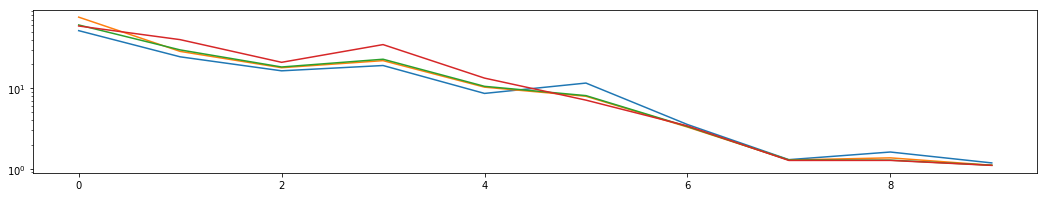

In [4]:
if __name__ == '__main__':
    FCT_analysis = FCT("/home/ovs2/lining/Gearbox/automatic/obsolete/", "Topology-incast-singlenode.tcl",\
                   1000, \
                   [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95], \
                   # ["AFQ10", "HRCC", "DropTail", "AFQ100", "AFQ1000",\
                   ["DropTail-100", "DropTail-200", "DropTail", "DropTail-500", "DropTail-1000", "DropTail-1500", "DropTail-2000"])
    # Byte
    flow_size=[0, 6, 13, 19, 33, 53, 133, 1333, 3333, 6667, float('inf')]
    print([FCT_analysis.humanbytes(i*1500) for i in flow_size])
    #algs=["AFQ10", "HRCC", "DropTail", "AFQ100", "AFQ1000"]
    #algs=["HRCC", "AFQ1000", "AFQ100"]
    algs=["DropTail-100", "DropTail-200", "DropTail", "DropTail-500", "DropTail-1000", "DropTail-1500", "DropTail-2000"]
    # when scale = [0,0], there is no adjust to the graph
    scale=[150,100]
    scale=[0,0]
    for load in [.1, .2, .3, .4, .5, .6, .7, .8, .9, .95]:
        FCT_analysis.plot_FCT_percentile_fix_load(algs, load, .95, flow_size, scale)

    FCT_analysis.plotting_mean_FCT()

    for alg in algs:
        FCT_analysis.plot_FCT_flowsize(alg, 0.5, label=alg, scale=[0, 0])